In [2]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [3]:
# Dataset config
TIME_BEG = 1451606400 # = year 2016
# TIME_BEG = 1546347600 # = year 2019
TIME_INTERVAL = 30 # minutes
LEN_ENCODE_SERIE = 48
LEN_DECODE_SERIE = 1

DISPLAY_SECTION_LEN = 100

In [4]:
# Read csv file
prices = None
with open('kaggle_1min.csv', 'r') as f:
    reader = csv.reader(f)
    prices = list(reader)

In [5]:
# Process with Panda dataframe
prices_df = pd.DataFrame(prices[1:], columns=prices[0])

print("Original dataframe: ", prices_df)

prices_df = prices_df.drop(columns=["Open", "High", "Low", "Close", "Volume_(Currency)"])
prices_df = prices_df.astype(float)
prices_df = prices_df.fillna(0) # Replace NaN with 0 (time where trade volume = 0)
prices_df = prices_df.loc[prices_df["Timestamp"] >= TIME_BEG] # Cut off from desired begin time
prices_df = prices_df.reset_index(drop=True)

print("Processed dataframe: ", prices_df)

Original dataframe:            Timestamp      Open      High       Low     Close Volume_(BTC)  \
0        1325317920      4.39      4.39      4.39      4.39   0.45558087   
1        1325317980       NaN       NaN       NaN       NaN          NaN   
2        1325318040       NaN       NaN       NaN       NaN          NaN   
3        1325318100       NaN       NaN       NaN       NaN          NaN   
4        1325318160       NaN       NaN       NaN       NaN          NaN   
...             ...       ...       ...       ...       ...          ...   
4727772  1609372560  28801.47  28829.42  28785.64  28829.42   0.96522104   
4727773  1609372620  28829.42   28863.9  28829.42  28857.06   2.36883117   
4727774  1609372680  28850.49  28900.52  28850.49  28882.82   2.46658976   
4727775  1609372740  28910.54  28911.52   28867.6   28881.3     7.332773   
4727776  1609372800  28893.21  28928.49  28893.21  28928.49   5.75767938   

        Volume_(Currency) Weighted_Price  
0            2.00000001

In [6]:
# Convert dataframe to torch tensor
prices_tensor = torch.from_numpy(prices_df.values)

In [7]:
# Summarize prices by each TIME_INTERVAL using Volume Weighted Average Price (VWAP) calculations
num_data = prices_tensor.shape[0] // TIME_INTERVAL
shape = (num_data, 3)
condensed_prices_tensor = torch.empty(shape)

j = 0
for i in range(0, prices_tensor.shape[0] - TIME_INTERVAL, TIME_INTERVAL):
    condensed_prices_tensor[j, 0] = prices_tensor[i, 0] # Time stamp

    # Calculate WVAP
    volume_weighted_sum = torch.sum(prices_tensor[i:i+TIME_INTERVAL, 1] * prices_tensor[i:i+TIME_INTERVAL, 2])
    total_volume = torch.sum(prices_tensor[i:i+TIME_INTERVAL, 1])
    wvap = volume_weighted_sum / total_volume

    # If no trade in this time interval use the price in the previous one
    # Here assume that first TIME_INTERVAL since TIME_BEG has > 0 trade volume
    if total_volume == 0:
        condensed_prices_tensor[j, 1] = condensed_prices_tensor[j-1, 1]
    else:
        condensed_prices_tensor[j, 1] = wvap
        
    # Store volume
    condensed_prices_tensor[j, 2] = total_volume
    
    j += 1

Original price data shape:  torch.Size([2629441, 3])
Time condensed price data shape:  torch.Size([87648, 3])
Condensed price data: 
 tensor([[1.4516e+09, 4.3169e+02, 2.0332e+01],
        [1.4516e+09, 4.3124e+02, 2.0989e+01],
        [1.4516e+09, 4.3037e+02, 1.9536e+01],
        ...,
        [1.6094e+09, 2.8768e+04, 1.3864e+02],
        [1.6094e+09, 2.8777e+04, 8.2922e+01],
        [1.6094e+09, 2.8873e+04, 5.9549e+01]])
Max price 28900.158203125
Min price 355.63970947265625
Mean price 6079.4765625
Standard deviation price 4661.35546875
tensor([[1.4516e+09, 4.3169e+02, 2.0332e+01],
        [1.4516e+09, 4.3124e+02, 2.0989e+01],
        [1.4516e+09, 4.3037e+02, 1.9536e+01],
        [1.4516e+09, 4.3011e+02, 1.1676e+01],
        [1.4516e+09, 4.3067e+02, 8.2690e+00],
        [1.4516e+09, 4.3071e+02, 3.9772e+00],
        [1.4516e+09, 4.3111e+02, 8.8192e+00],
        [1.4516e+09, 4.3264e+02, 6.6165e+01],
        [1.4516e+09, 4.3414e+02, 6.0028e+02],
        [1.4516e+09, 4.3489e+02, 2.7052e+02]

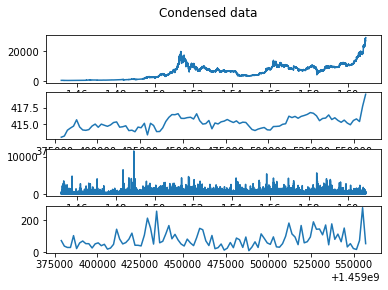

In [22]:
print("Original price data shape: ", prices_tensor.shape)
print("Time condensed price data shape: ", condensed_prices_tensor.shape)
print("Condensed price data: \n", condensed_prices_tensor)

time_x = condensed_prices_tensor[:,0]
price_y = condensed_prices_tensor[:,1]
volume_y = condensed_prices_tensor[:,2]
section_start = random.randint(0, len(condensed_prices_tensor) - DISPLAY_SECTION_LEN)

fig, axs = plt.subplots(4)
fig.suptitle('Condensed data')
axs[0].plot(time_x, price_y)
axs[1].plot(time_x[section_start:section_start+DISPLAY_SECTION_LEN], price_y[section_start:section_start+DISPLAY_SECTION_LEN])
axs[2].plot(time_x, volume_y)
axs[3].plot(time_x[section_start:section_start+DISPLAY_SECTION_LEN], volume_y[section_start:section_start+DISPLAY_SECTION_LEN])

mini = torch.min(condensed_prices_tensor[:,1])
maxi = torch.max(condensed_prices_tensor[:,1])
mean = torch.mean(condensed_prices_tensor[:,1])
std = torch.std(condensed_prices_tensor[:,1])

print("Max price", maxi.item())
print("Min price", mini.item())
print("Mean price", mean.item())
print("Standard deviation price", std.item())

Max 2369.541259765625
Min -1627.21728515625
Mean 0.624636173248291
Standard deviation 53.86668014526367
percentile_lowest -21.62166061401367
percentile_lower -4.473546028137207
percentile_higher 6.618721294403076
percentile_highest 24.23151893615723


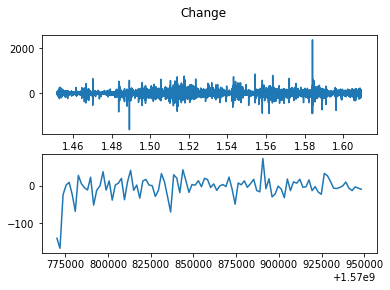

In [33]:
# Convert price to change in price in one ten thousanth
price_change = (condensed_prices_tensor[1:, 1] - condensed_prices_tensor[:-1, 1]) / condensed_prices_tensor[:-1, 1]
price_change *= 10000

mini = torch.min(price_change).item()
maxi = torch.max(price_change).item()
mean = torch.mean(price_change).item()
std = torch.std(price_change).item()
percentile_lowest = np.percentile(price_change.numpy(), 20).item()
percentile_lower = np.percentile(price_change.numpy(), 40).item()
percentile_higher = np.percentile(price_change.numpy(), 60).item()
percentile_highest = np.percentile(price_change.numpy(), 80).item()

print("Max", maxi)
print("Min", mini)
print("Mean", mean)
print("Standard deviation", std)
print("percentile_lowest", percentile_lowest)
print("percentile_lower", percentile_lower)
print("percentile_higher", percentile_higher)
print("percentile_highest", percentile_highest)

time_x = condensed_prices_tensor[1:, 0]
price_change_y = price_change
section_start = random.randint(0, len(price_change) - DISPLAY_SECTION_LEN)

fig, axs = plt.subplots(2)
fig.suptitle('Change')
axs[0].plot(time_x, price_change_y)
axs[1].plot(time_x[section_start:section_start+DISPLAY_SECTION_LEN], price_change_y[section_start:section_start+DISPLAY_SECTION_LEN])


In [34]:
# Checking for nan data
assert(torch.sum(price_change != price_change) == 0)

Max 43.97739791870117
Min -30.219829559326172
Mean 4.526435670726414e-09
Standard deviation 1.0
percentile_lowest -0.4129880666732788
percentile_lower -0.09464444667100906
percentile_higher 0.11127630770206451
percentile_highest 0.4382464945316315


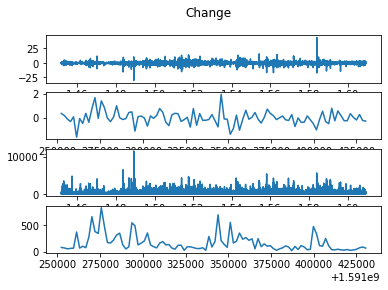

In [35]:
# Normalize
price_change = (price_change - mean) / std

mini = torch.min(price_change).item()
maxi = torch.max(price_change).item()
mean = torch.mean(price_change).item()
std = torch.std(price_change).item()

print("Max", maxi)
print("Min", mini)
print("Mean", mean)
print("Standard deviation", std)

price_change = torch.cat([price_change.unsqueeze(1), condensed_prices_tensor[1:, 2].unsqueeze(1)], dim=1)

time_x = condensed_prices_tensor[1:, 0]
price_change_y = price_change[:, 0]
volume_y = price_change[:, 1] 
section_start = random.randint(0, len(price_change) - DISPLAY_SECTION_LEN)

fig, axs = plt.subplots(4)
fig.suptitle('Change')
axs[0].plot(time_x, price_change_y)
axs[1].plot(time_x[section_start:section_start+DISPLAY_SECTION_LEN], price_change_y[section_start:section_start+DISPLAY_SECTION_LEN])
axs[2].plot(time_x, volume_y)
axs[3].plot(time_x[section_start:section_start+DISPLAY_SECTION_LEN], volume_y[section_start:section_start+DISPLAY_SECTION_LEN])


In [53]:
# Make input time serie data and target time serie data tensor 
num_data = (len(condensed_prices_tensor) - LEN_ENCODE_SERIE - LEN_DECODE_SERIE) // LEN_DECODE_SERIE

X_shape = (num_data, LEN_ENCODE_SERIE, 2)
y_shape = (num_data, LEN_DECODE_SERIE)

X, y = torch.empty(X_shape), torch.empty(y_shape)

for i in range(num_data):
    start = i * LEN_DECODE_SERIE
    X[i] = price_change[start:start+LEN_ENCODE_SERIE]
    y[i] = price_change[start+LEN_ENCODE_SERIE:start+LEN_ENCODE_SERIE+LEN_DECODE_SERIE, 0]


In [54]:
# print(y)
# y = (y > percentile_highest).float() + (y > percentile_higher).float() + (y > percentile_lower).float() + (y > percentile_lowest).float() - 2
# y = (y > percentile_higher).float() + (y > percentile_lower).float() - 1
print(y)


tensor([[ 0.0638],
        [-0.2674],
        [-0.9382],
        ...,
        [-0.5149],
        [ 0.0457],
        [ 0.6119]])
torch.Size([87599, 1])
torch.Size([87647, 2])


In [55]:
print("Encode time serie data shape:", X_shape)
print("Decode time serie data shape:", y_shape)
print("Training X:\n", X)
print("Training y:\n", y)
print(torch.sum(y == 0))
print(torch.sum(y == 1))
print(torch.sum(y == -1))

Encode time serie data shape: (87599, 48, 2)
Decode time serie data shape: (87599, 1)
Training X:
 tensor([[[-2.0378e-01,  2.0989e+01],
         [-3.8907e-01,  1.9536e+01],
         [-1.2163e-01,  1.1676e+01],
         ...,
         [ 4.7755e-01,  3.4761e+01],
         [-1.9763e-01,  5.1488e+01],
         [ 4.9127e-01,  2.8478e+02]],

        [[-3.8907e-01,  1.9536e+01],
         [-1.2163e-01,  1.1676e+01],
         [ 2.2803e-01,  8.2690e+00],
         ...,
         [-1.9763e-01,  5.1488e+01],
         [ 4.9127e-01,  2.8478e+02],
         [ 6.3838e-02,  1.4746e+02]],

        [[-1.2163e-01,  1.1676e+01],
         [ 2.2803e-01,  8.2690e+00],
         [ 9.6098e-03,  3.9772e+00],
         ...,
         [ 4.9127e-01,  2.8478e+02],
         [ 6.3838e-02,  1.4746e+02],
         [-2.6742e-01,  3.4916e+01]],

        ...,

        [[-1.7007e-01,  1.0252e+02],
         [ 4.9306e-01,  9.5330e+01],
         [ 1.5246e+00,  2.1304e+02],
         ...,
         [-7.5504e-01,  2.6745e+02],
         [ 

In [56]:
torch.save(X, "./../X.pt")
torch.save(y, "./../y.pt")